# Anderson Localization

Rafael A. Molina Instituto de Estructura de la Materia (CSIC)

rafael.molina@csic.es

This notebook provides an **interactive introduction to Anderson localization**:
- 1D Anderson model with a slider to change disorder and inspect eigenstates
- Density of States (DOS) and localization length vs. energy and disorder
- Time evolution of a Gaussian wave packet showing absence of diffusion
- Participation Ratio (PR) / Inverse Participation Ratio (IPR)
- Lyapunov exponent via the transfer-matrix method
- Extension to 2D on square and honeycomb lattices

> Run the cells from top to bottom. Plots use pure matplotlib and widgets are built with ipywidgets.

In [13]:
#@title Install & Imports (Colab-friendly)
# If running in Colab, widgets support should be available; if not, uncomment the pip line:
# !pip -q install ipywidgets==8.1.5

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.linalg as la
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider, IntSlider, IntText, fixed, Dropdown, Checkbox
from IPython.display import display, clear_output

np.random.seed(0)

def set_default_rc():
    plt.rcParams.update({
        "figure.figsize": (6,4),
        "axes.grid": False,
    })

set_default_rc()
print("Ready. NumPy:", np.__version__)

Ready. NumPy: 2.0.2


## Utilities

In [2]:
def uniform_disorder(N, W, rng=None):
    # Uniform onsite disorder in [-W/2, W/2]
    if rng is None:
        rng = np.random.default_rng()
    return rng.uniform(-W/2, W/2, size=N)

def anderson_1d_hamiltonian(N, t=1.0, W=0.0, periodic=False, rng=None):
    # 1D tight-binding with onsite disorder and nearest-neighbor hopping
    eps = uniform_disorder(N, W, rng)
    diag = eps
    off = -t*np.ones(N-1)
    H = sp.diags([off, diag, off], offsets=[-1,0,1], format="csr")
    if periodic and N > 2:
        H = H.tolil()
        H[0, -1] = -t
        H[-1, 0] = -t
        H = H.tocsr()
    return H, eps

def sorted_spectrum(H):
    A = H.toarray() if sp.issparse(H) else H
    w, v = la.eigh(A)
    idx = np.argsort(w)
    return w[idx], v[:, idx]

def gaussian_wavepacket(N, x0, sigma):
    x = np.arange(N)
    psi = np.exp(-0.5*((x - x0)/sigma)**2)
    psi = psi / la.norm(psi)
    return psi.astype(np.complex128)

def msd(psi):
    N = psi.size
    x = np.arange(N)
    prob = np.abs(psi)**2
    mean = np.sum(x*prob)
    return np.sum(((x-mean)**2)*prob)

def evolve_state(H, psi0, times):
    # Unitary evolution psi(t)=exp(-iHt) psi(0) using expm_multiply
    if not sp.issparse(H):
        H = sp.csr_matrix(H)
    results = []
    for t in times:
        psi_t = spla.expm_multiply((-1j)*H, psi0, start=0, stop=t, num=2)[-1]
        results.append(psi_t)
    return np.array(results, dtype=np.complex128)

def participation_ratios(vecs):
    # PR = 1 / sum |psi_n|^4, IPR = sum |psi_n|^4
    if vecs.ndim == 1:
        vecs = vecs[:,None]
    probs4 = np.sum(np.abs(vecs)**4, axis=0)
    ipr = probs4
    pr = 1.0 / probs4
    return pr, ipr

## 1D Anderson chain — interactive eigenstates

In [3]:
#@title Interactive 1D Eigenstates
N = 200 #@param {type:"integer"}
t = 1.0 #@param {type:"number"}
periodic = False #@param {type:"boolean"}

#def plot_eigenstate(W=1.0, n=0):
#    H, eps = anderson_1d_hamiltonian(N, t=t, W=W, periodic=periodic)
    # w, v = sorted_spectrum(H)
    # n = int(np.clip(n, 0, N-1))
    # plt.figure()
    # plt.title(f"Eigenstate index {n} — E = {w[n]:.3f} (W={W:.2f})")
    # plt.xlabel("site n")
    # plt.ylabel("|psi_n|^2")
    # plt.plot(np.arange(N), np.abs(v[:,n])**2)
    # plt.tight_layout()
    # plt.show()

def plot_eigenstate(W=1.0, n=0):
    H, eps = anderson_1d_hamiltonian(N, t=t, W=W, periodic=periodic)
    w, v = sorted_spectrum(H)
    n = int(np.clip(n, 0, N-1))
    psi2 = np.abs(v[:, n])**2

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

    # --- Linear scale ---
    ax1.plot(np.arange(N), psi2)
    ax1.set_ylabel(r"$|\psi_n|^2$")
    ax1.set_title(f"Eigenstate {n} — E = {w[n]:.3f} (W={W:.2f})")

    # --- Log scale ---
    ax2.plot(np.arange(N), psi2 + 1e-15)  # add offset to avoid log(0)
    ax2.set_yscale("log")
    ax2.set_xlabel("site n")
    ax2.set_ylabel(r"$|\psi_n|^2$ (log scale)")

    plt.tight_layout()
    plt.show()


_ = interact(
    plot_eigenstate,
    W=FloatSlider(value=1.0, min=0.0, max=10.0, step=0.1, description="Disorder W"),
    n=IntSlider(value=50, min=0, max=N-1, step=1, description="Eigenstate #")
)

interactive(children=(FloatSlider(value=1.0, description='Disorder W', max=10.0), IntSlider(value=50, descript…

## Density of States (DOS) vs disorder

In [4]:
#@title DOS for multiple disorder realizations
def compute_dos(N=200, W=2.0, n_real=40, bins=60, periodic=False):
    all_eigs = []
    rng = np.random.default_rng(123)
    for _ in range(n_real):
        H, _ = anderson_1d_hamiltonian(N, W=W, periodic=periodic, rng=rng)
        w, _ = sorted_spectrum(H)
        all_eigs.append(w)
    all_eigs = np.concatenate(all_eigs)
    plt.figure()
    plt.title(f"DOS estimate (histogram) — N={N}, W={W}, realizations={n_real}")
    plt.xlabel("Energy E")
    plt.ylabel("Density (arb. units)")
    plt.hist(all_eigs, bins=bins, density=True)
    plt.tight_layout()
    plt.show()

_ = interact(
    compute_dos,
    N=IntSlider(value=200, min=50, max=600, step=50, description="N"),
    W=FloatSlider(value=2.0, min=0.0, max=10.0, step=0.2, description="W"),
    n_real=IntSlider(value=40, min=5, max=100, step=5, description="#real"),
    bins=IntSlider(value=60, min=20, max=200, step=10, description="#bins"),
    periodic=Checkbox(value=False, description="Periodic BC")
)

interactive(children=(IntSlider(value=200, description='N', max=600, min=50, step=50), FloatSlider(value=2.0, …

## Lyapunov exponent via transfer matrices (1D)

The **1D Anderson model** describes a quantum particle on a disordered lattice through the tight-binding equation


$\psi_{n+1} + \psi_{n-1} + (\varepsilon_n - E)\psi_n = 0$,

where $E$ is the energy, and $\varepsilon_n \in [-W/2,, W/2]$ are random on-site potentials drawn from a uniform distribution of width $W$.
This equation can be rewritten in **transfer-matrix form** by defining the two-component vector


$\mathbf{v}_n =
\begin{pmatrix}
\psi_n \\
\psi_{n-1}
\end{pmatrix},
\qquad
\mathbf{v}_{n+1} =
T_n \mathbf{v}_n$,

with the **local transfer matrix**


$T_n =
\begin{pmatrix}
E - \varepsilon_n & -1 \\
1 & 0
\end{pmatrix}$.


The total evolution over $N$ sites is then given by the product

$\mathbf{v}_N = \left( \prod_{n=1}^N T_n \right) \mathbf{v}_0$ .
In the localized regime, the amplitude $|\psi_n|$ typically decays exponentially with $n$, characterized by the **Lyapunov exponent**

$\gamma = \lim_{N \to \infty} \frac{1}{N} , \big\langle \ln |\mathbf{v}_N| \big\rangle$,

which is the inverse **localization length**, $\xi = 1/\gamma$.

In the implementation below, the code multiplies random transfer matrices iteratively, periodically **renormalizing** the vector to prevent numerical overflow and accumulating the logarithm of its norm. The resulting average growth rate of the norm gives the Lyapunov exponent $\gamma(E)$ as a function of energy. Sweeping over energy values yields the characteristic **mobility profile** for a given disorder strength $W$.


In [5]:
#@title Transfer Matrix Method for 1D
def lyapunov_exponent_1d(E, W, N=20000, block=200, rng=None):
    # ψ_{n+1} + ψ_{n-1} + (ε_n - E) ψ_n = 0  (t=1 convention)
    if rng is None:
        rng = np.random.default_rng()
    eps = uniform_disorder(N, W, rng)
    v = np.array([1.0, 0.0])
    M_logs = 0.0
    steps = 0
    for i in range(N):
        a = (E - eps[i])
        T = np.array([[a, -1.0],
                      [1.0,  0.0]], dtype=np.float64)
        v = T @ v
        if (i+1) % block == 0:
            M_logs += np.log(np.linalg.norm(v))
            v = v / np.linalg.norm(v)
            steps += block
    if steps < N:
        M_logs += np.log(np.linalg.norm(v))
        steps = N
    gamma = M_logs / steps
    return gamma


def lyapunov_and_localization_curve(W=2.0, Emin=-3.0, Emax=3.0, nE=61, N=50000):
    EE = np.linspace(Emin, Emax, nE)
    gammas = np.array([lyapunov_exponent_1d(E, W, N=N) for E in EE])
    xi = 1.0 / np.maximum(gammas, 1e-12)  # regularize to avoid infinities

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6), sharex=True)

    # --- Top panel: Lyapunov exponent ---
    ax1.plot(EE, gammas, color="C0")
    ax1.set_ylabel(r"$\gamma(E)$")
    ax1.set_title(f"Lyapunov exponent and localization length — W={W}, N={N}")
    ax1.grid(True, ls="--", alpha=0.4)

    # --- Bottom panel: Localization length ---
    ax2.plot(EE, xi, color="C1")
    ax2.set_xlabel("Energy E")
    ax2.set_ylabel(r"$\xi(E) = 1/\gamma(E)$")
    ax2.grid(True, ls="--", alpha=0.4)

    plt.tight_layout()
    plt.show()


_ = interact(
    lyapunov_and_localization_curve,
    W=FloatSlider(value=2.0, min=0.0, max=10.0, step=0.2, description="W"),
    Emin=FloatSlider(value=-3.0, min=-6.0, max=0.0, step=0.2, description="Emin"),
    Emax=FloatSlider(value=3.0, min=0.0, max=6.0, step=0.2, description="Emax"),
    nE=IntSlider(value=61, min=21, max=201, step=10, description="#E points"),
    N=IntSlider(value=50000, min=5000, max=200000, step=5000, description="chain length"),
)

# def lyapunov_curve(W=2.0, Emin=-3.0, Emax=3.0, nE=61, N=50000):
#     EE = np.linspace(Emin, Emax, nE)
#     gammas = np.array([lyapunov_exponent_1d(E, W, N=N) for E in EE])
#     plt.figure()
#     plt.title(f"Lyapunov exponent gamma(E) — W={W}, N={N}")
#     plt.xlabel("Energy E")
#     plt.ylabel("gamma(E)")
#     plt.plot(EE, gammas)
#     plt.tight_layout()
#     plt.show()

# _ = interact(
#     lyapunov_curve,
#     W=FloatSlider(value=2.0, min=0.0, max=10.0, step=0.2, description="W"),
#     Emin=FloatSlider(value=-3.0, min=-6.0, max=0.0, step=0.2, description="Emin"),
#     Emax=FloatSlider(value=3.0, min=0.0, max=6.0, step=0.2, description="Emax"),
#     nE=IntSlider(value=61, min=21, max=201, step=10, description="#E points"),
#     N=IntSlider(value=50000, min=5000, max=200000, step=5000, description="chain length")
# )

interactive(children=(FloatSlider(value=2.0, description='W', max=10.0, step=0.2), FloatSlider(value=-3.0, des…

## Time evolution of a Gaussian wave packet (absence of diffusion)

In [9]:
#@title Wave packet dynamics in 1D
def wavepacket_demo(N=400, W=4.0, x0=200, sigma=8.0, tmax=50.0, nsteps=101, periodic=False):
    H, _ = anderson_1d_hamiltonian(N, W=W, periodic=periodic)
    psi0 = gaussian_wavepacket(N, x0=x0, sigma=sigma)
    times = np.linspace(0.0, tmax, nsteps)
    psis = evolve_state(H, psi0, times)
    msds = np.array([msd(psi) for psi in psis])
    # MSD vs time
    plt.figure()
    plt.title(f"Mean Square Displacement vs time — W={W}")
    plt.xlabel("time")
    plt.ylabel("<(x-<x>)^2>")
    plt.plot(times, msds)
    plt.tight_layout()
    plt.show()
    # Snapshot at final time
    plt.figure()
    plt.title(f"Probability density at t = {tmax:.2f}")
    plt.xlabel("site n"); plt.ylabel("|psi_n|^2")
    plt.plot(np.arange(N), np.abs(psis[-1])**2)
    plt.tight_layout()
    plt.show()
    # Now in log scale
    plt.figure()
    plt.title(f"Probability density at t = {tmax:.2f} (log scale)")
    plt.xlabel("site n"); plt.ylabel("|psi_n|^2 (log scale)")
    plt.yscale("log")
    plt.plot(np.arange(N), np.abs(psis[-1])**2)
    plt.tight_layout()
    plt.show()

_ = interact(
    wavepacket_demo,
    N=IntSlider(value=400, min=200, max=800, step=50, description="N"),
    W=FloatSlider(value=4.0, min=0.0, max=10.0, step=0.5, description="W"),
    x0=IntSlider(value=200, min=50, max=350, step=5, description="x0"),
    sigma=FloatSlider(value=8.0, min=2.0, max=30.0, step=1.0, description="sigma"),
    tmax=FloatSlider(value=50.0, min=10.0, max=200.0, step=5.0, description="t_max"),
    nsteps=IntSlider(value=101, min=21, max=401, step=20, description="#steps"),
    periodic=Checkbox(value=False, description="Periodic BC")
)

interactive(children=(IntSlider(value=400, description='N', max=800, min=200, step=50), FloatSlider(value=4.0,…

## Participation Ratio (PR) and Inverse PR (IPR)

In [11]:
#@title PR / IPR across the spectrum
def pr_ipr_spectrum(N=300, W=3.0, periodic=False):
    H, _ = anderson_1d_hamiltonian(N, W=W, periodic=periodic)
    w, v = sorted_spectrum(H)
    pr, ipr = participation_ratios(v)
    plt.figure()
    plt.title(f"PR vs E — N={N}, W={W}")
    plt.xlabel("Energy E"); plt.ylabel("PR")
    plt.plot(w, pr)
    plt.tight_layout()
    plt.show()
    plt.figure()
    plt.title(f"IPR vs E — N={N}, W={W}")
    plt.xlabel("Energy E"); plt.ylabel("IPR")
    plt.plot(w, ipr)
    plt.tight_layout()
    plt.show()

_ = interact(
    pr_ipr_spectrum,
    N=IntSlider(value=300, min=100, max=800, step=50, description="N"),
    W=FloatSlider(value=3.0, min=0.0, max=10.0, step=0.5, description="W"),
    periodic=Checkbox(value=False, description="Periodic BC")
)

interactive(children=(IntSlider(value=300, description='N', max=800, min=100, step=50), FloatSlider(value=3.0,…

## Averaging PR for many disorder realizations




In [14]:
def pr_ipr_spectrum_avg(N=300, W=3.0, periodic=False, nreal=50, nbins=61, seed=0):
    """
    Average PR and IPR across many disorder realizations by binning in energy.
    Assumes:
      - anderson_1d_hamiltonian(N, W, periodic) -> (H, eps)
      - sorted_spectrum(H) -> (w, v) with v[:,i] the eigenvector for w[i]
      - participation_ratios(v) -> (pr, ipr) arrays matching eigenvalues
    """
    rng = np.random.default_rng(seed)

    # Choose fixed energy bins spanning the broadened band:
    # clean band is [-2, 2]; disorder roughly broadens by ±W/2
    Emin = -2.0 - W/2.0
    Emax =  2.0 + W/2.0
    edges = np.linspace(Emin, Emax, nbins+1)
    centers = 0.5*(edges[:-1] + edges[1:])

    # Accumulators for mean and variance estimation
    sum_pr   = np.zeros(nbins, dtype=float)
    sum_ipr  = np.zeros(nbins, dtype=float)
    sum_pr2  = np.zeros(nbins, dtype=float)
    sum_ipr2 = np.zeros(nbins, dtype=float)
    counts   = np.zeros(nbins, dtype=int)

    for _ in range(nreal):
        H, _ = anderson_1d_hamiltonian(N, W=W, periodic=periodic, rng=rng)
        w, v = sorted_spectrum(H)
        pr, ipr = participation_ratios(v)   # shape (N,)

        # Bin by eigenvalue
        idx = np.digitize(w, edges) - 1   # map to 0..nbins-1
        valid = (idx >= 0) & (idx < nbins)

        # Accumulate
        np.add.at(sum_pr,   idx[valid], pr[valid])
        np.add.at(sum_ipr,  idx[valid], ipr[valid])
        np.add.at(sum_pr2,  idx[valid], pr[valid]**2)
        np.add.at(sum_ipr2, idx[valid], ipr[valid]**2)
        np.add.at(counts,   idx[valid], 1)

    # Compute means and standard errors where we have data
    mask = counts > 0
    mean_pr  = np.zeros_like(sum_pr);  mean_ipr  = np.zeros_like(sum_ipr)
    sem_pr   = np.zeros_like(sum_pr);  sem_ipr   = np.zeros_like(sum_ipr)

    mean_pr[mask]  = sum_pr[mask]  / counts[mask]
    mean_ipr[mask] = sum_ipr[mask] / counts[mask]

    # unbiased variance estimate then SEM
    var_pr = np.zeros_like(sum_pr); var_ipr = np.zeros_like(sum_ipr)
    with np.errstate(invalid='ignore', divide='ignore'):
        var_pr[mask]  = (sum_pr2[mask]  / counts[mask]) - mean_pr[mask]**2
        var_ipr[mask] = (sum_ipr2[mask] / counts[mask]) - mean_ipr[mask]**2
        sem_pr[mask]  = np.sqrt(np.maximum(var_pr[mask], 0.0) / counts[mask])
        sem_ipr[mask] = np.sqrt(np.maximum(var_ipr[mask], 0.0) / counts[mask])

    # --- Plot PR ---
    plt.figure(figsize=(6.5, 3.6))
    plt.title(f"PR vs E (averaged) — N={N}, W={W}, realizations={nreal}")
    plt.xlabel("Energy E"); plt.ylabel("PR")
    plt.plot(centers[mask], mean_pr[mask])
    # Shaded error band
    plt.fill_between(centers[mask], mean_pr[mask]-sem_pr[mask], mean_pr[mask]+sem_pr[mask], alpha=0.25)
    plt.tight_layout()
    plt.show()

    # --- Plot IPR ---
    plt.figure(figsize=(6.5, 3.6))
    plt.title(f"IPR vs E (averaged) — N={N}, W={W}, realizations={nreal}")
    plt.xlabel("Energy E"); plt.ylabel("IPR")
    plt.plot(centers[mask], mean_ipr[mask])
    plt.fill_between(centers[mask], mean_ipr[mask]-sem_ipr[mask], mean_ipr[mask]+sem_ipr[mask], alpha=0.25)
    plt.tight_layout()
    plt.show()

_ = interact(
    pr_ipr_spectrum_avg,
    N=IntSlider(value=300, min=100, max=800, step=50, description="N"),
    W=FloatSlider(value=3.0, min=0.0, max=10.0, step=0.5, description="W"),
    periodic=Checkbox(value=False, description="Periodic BC"),
    nreal=IntSlider(value=50, min=5, max=500, step=5, description="#realizations"),
    nbins=IntSlider(value=61, min=21, max=201, step=10, description="#E bins"),
    seed=IntText(value=0, description="seed"),
)

interactive(children=(IntSlider(value=300, description='N', max=800, min=100, step=50), FloatSlider(value=3.0,…

## Scaling of participation ratio

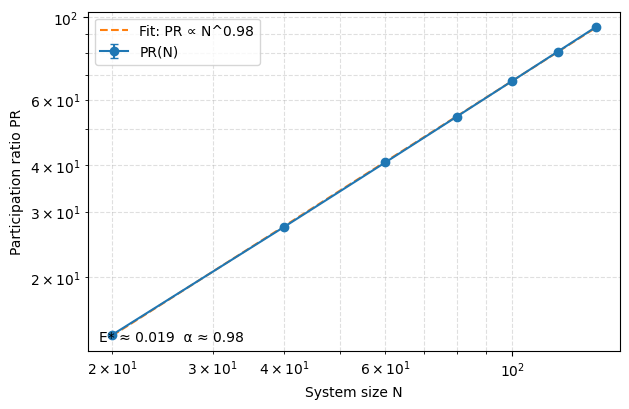

In [26]:
# Fallback PR helper
def _pr_from_vec(psi):
    norm = np.linalg.norm(psi)
    if norm == 0:
        return np.nan
    p4 = np.sum(np.abs(psi / norm)**4)
    return 1.0 / p4

def _pr_of_eigen_closest_to_E(H, E_target):
    # Uses your sorted_spectrum(H) -> (eigs, vecs) with vecs[:,i] for eigs[i]
    w, v = sorted_spectrum(H)
    idx = int(np.argmin(np.abs(w - E_target)))
    # If you already have participation_ratios(v), use it; else compute here
    try:
        from inspect import signature
        # try to call your participation_ratios if present
        pr_all = participation_ratios(v)[0]  # assumes (pr, ipr) return
        pr = float(pr_all[idx])
    except Exception:
        pr = _pr_from_vec(v[:, idx])
    return float(w[idx]), pr

def pr_scaling_fixed_E(
    E_target=0.0, W=2.0,
    N_list=None, nreal=50, periodic=False, seed=0,
    show_fit=True
):
    """
    Compute PR(N) for the eigenstate closest to E_target, averaged over nreal
    disorder realizations for each system size N in N_list.
    """
    if N_list is None:
        # Choose a reasonably broad size range
        N_list = np.array([20, 40, 60, 80, 100, 120, 140], dtype=int)

    rng_master = np.random.default_rng(seed)
    means, stds, mean_E = [], [], []

    for N in N_list:
        prs = []
        Es  = []
        # independent realizations for this N
        for _ in range(nreal):
            rng = np.random.default_rng(rng_master.integers(0, 2**63-1))
            # Your Hamiltonian builder should accept (N, W, periodic) and ideally rng=...
            try:
                H, _ = anderson_1d_hamiltonian(N, W=W, periodic=periodic, rng=rng)
            except TypeError:
                H, _ = anderson_1d_hamiltonian(N, W=W, periodic=periodic)  # if no rng param
            Ei, pri = _pr_of_eigen_closest_to_E(H, E_target)
            prs.append(pri); Es.append(Ei)
        prs = np.array(prs, dtype=float)
        Es  = np.array(Es, dtype=float)
        means.append(np.nanmean(prs))
        stds.append(np.nanstd(prs, ddof=1))
        mean_E.append(np.mean(Es))

    means = np.array(means); stds = np.array(stds); mean_E = np.array(mean_E)

    # --- Plot PR vs N with error bars (log–log) ---
    fig, ax = plt.subplots(figsize=(6.4, 4.2))
    ax.errorbar(N_list, means, yerr=stds/np.sqrt(nreal), fmt='o-', capsize=3, label="PR(N)")
    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_xlabel("System size N")
    ax.set_ylabel("Participation ratio PR")
    ax.grid(True, which="both", ls="--", alpha=0.4)

    # Optional: power-law fit PR ~ N^alpha using log–log linear regression
    fit_txt = ""
    if show_fit:
        mask = np.isfinite(means) & (means > 0)
        x = np.log(N_list[mask].astype(float))
        y = np.log(means[mask])
        if x.size >= 2:
            A = np.vstack([x, np.ones_like(x)]).T
            alpha, logA = np.linalg.lstsq(A, y, rcond=None)[0]  # slope, intercept
            Nfit = np.linspace(N_list[mask].min(), N_list[mask].max(), 200)
            ax.plot(Nfit, np.exp(logA) * Nfit**alpha, '--', label=f"Fit: PR ∝ N^{alpha:.2f}")
            fit_txt = f"α ≈ {alpha:.2f}"
            ax.legend()
    # Annotate average picked energy (helps verify the eigenstate selection)
    picked_E = np.mean(mean_E)
    ax.text(0.02, 0.03, f"E* ≈ {picked_E:.3f}  {fit_txt}", transform=ax.transAxes)

    plt.tight_layout()
    plt.show()

    return {
        "N": np.array(N_list, dtype=int),
        "PR_mean": means,
        "PR_sem": stds/np.sqrt(nreal),
        "E_selected_mean": picked_E
    }


res = pr_scaling_fixed_E(E_target=0.0, W=0.0, nreal=50, periodic=False, seed=1)


## 2D extensions: square and honeycomb lattices



In [15]:
#@title 2D: builders for square and honeycomb lattices (open boundaries)
def idx_2d(i, j, Lx, Ly):
    return i + j*Lx

def anderson_2d_square(Lx, Ly, t=1.0, W=0.0, rng=None):
    N = Lx*Ly
    if rng is None: rng = np.random.default_rng()
    eps = uniform_disorder(N, W, rng)
    H = sp.lil_matrix((N, N), dtype=np.float64)
    H.setdiag(eps)
    for j in range(Ly):
        for i in range(Lx):
            p = idx_2d(i,j,Lx,Ly)
            if i+1 < Lx:
                q = idx_2d(i+1,j,Lx,Ly)
                H[p,q] = H[q,p] = -t
            if j+1 < Ly:
                q = idx_2d(i,j+1,Lx,Ly)
                H[p,q] = H[q,p] = -t
    return H.tocsr()

def honeycomb_neighbors(Lx, Ly):
    # Rectangular patch of honeycomb with 2 atoms per unit cell (A,B)
    def idx(u,v,s): return s + 2*(u + v*Lx)
    N = 2*Lx*Ly
    rows, cols = [], []
    for v in range(Ly):
        for u in range(Lx):
            a = idx(u,v,0)
            b = idx(u,v,1)
            rows += [a,b]; cols += [b,a]
            if u+1 < Lx:
                rows += [b]; cols += [idx(u+1,v,0)]
                rows += [idx(u+1,v,0)]; cols += [b]
            if v+1 < Ly:
                rows += [a]; cols += [idx(u,v+1,1)]
                rows += [idx(u,v+1,1)]; cols += [a]
    return np.array(rows), np.array(cols), N

def anderson_2d_honeycomb(Lx, Ly, t=1.0, W=0.0, rng=None):
    if rng is None: rng = np.random.default_rng()
    rows, cols, N = honeycomb_neighbors(Lx, Ly)
    H = sp.csr_matrix((np.full(rows.size, -t), (rows, cols)), shape=(N,N))
    eps = uniform_disorder(N, W, rng)
    H = H + sp.diags(eps, format="csr")
    return H

In [16]:
#@title 2D Square lattice: DOS and IPR
def square_2d_demo(Lx=20, Ly=20, W=2.0, bins=80):
    H = anderson_2d_square(Lx, Ly, W=W)
    w, v = la.eigh(H.toarray())
    pr, ipr = participation_ratios(v)
    plt.figure()
    plt.title(f"Square Lattice DOS — {Lx}x{Ly}, W={W}")
    plt.xlabel("E"); plt.ylabel("Density (arb. units)")
    plt.hist(w, bins=bins, density=True)
    plt.tight_layout()
    plt.show()
    plt.figure()
    plt.title("IPR vs E (2D square)")
    plt.xlabel("E"); plt.ylabel("IPR")
    plt.plot(w, ipr)
    plt.tight_layout()
    plt.show()

_ = interact(
    square_2d_demo,
    Lx=IntSlider(value=20, min=8, max=40, step=2, description="Lx"),
    Ly=IntSlider(value=20, min=8, max=40, step=2, description="Ly"),
    W=FloatSlider(value=2.0, min=0.0, max=8.0, step=0.2, description="W"),
    bins=IntSlider(value=80, min=20, max=160, step=10, description="#bins")
)

interactive(children=(IntSlider(value=20, description='Lx', max=40, min=8, step=2), IntSlider(value=20, descri…

In [17]:
#@title 2D Honeycomb lattice: DOS and IPR
def honeycomb_2d_demo(Lx=16, Ly=16, W=0.5, bins=80):
    H = anderson_2d_honeycomb(Lx, Ly, W=W)
    w, v = la.eigh(H.toarray())
    pr, ipr = participation_ratios(v)
    plt.figure()
    plt.title(f"Honeycomb DOS — {Lx}x{Ly} cells, W={W}")
    plt.xlabel("E"); plt.ylabel("Density (arb. units)")
    plt.hist(w, bins=bins, density=True)
    plt.tight_layout()
    plt.show()
    plt.figure()
    plt.title("IPR vs E (2D honeycomb)")
    plt.xlabel("E"); plt.ylabel("IPR")
    plt.plot(w, ipr)
    plt.tight_layout()
    plt.show()

_ = interact(
    honeycomb_2d_demo,
    Lx=IntSlider(value=16, min=8, max=28, step=2, description="Lx(cells)"),
    Ly=IntSlider(value=16, min=8, max=28, step=2, description="Ly(cells)"),
    W=FloatSlider(value=0.5, min=0.0, max=5.0, step=0.1, description="W"),
    bins=IntSlider(value=80, min=20, max=160, step=10, description="#bins")
)

interactive(children=(IntSlider(value=16, description='Lx(cells)', max=28, min=8, step=2), IntSlider(value=16,…

## Transfer Matrix in a Quasi‑1D 2D Square Strip

We consider a **strip of width** $M$ (transverse sites) and **length** $L$ (slices along $x$).
Each slice has an $M\times M$ Hamiltonian $H_n$ (onsite disorder + vertical couplings) and nearest‑neighbor coupling between slices.
The 2M×2M transfer matrix for slice $n$ is

  $T_n = \begin{pmatrix} E\,I - H_n & -I \\ I & 0 \end{pmatrix}$.

Periodic QR applied to the product $\prod_n T_n$ yields the **Lyapunov spectrum**; the **smallest positive** exponent $\gamma_{\min}$ gives the **quasi‑1D localization length** $\xi_M = 1/\gamma_{\min}$.

## QR Stabilization

Instead of computing $M_N$ directly, we periodically orthogonalize the evolving matrix product using QR decomposition.
•	The idea is to multiply by each transfer matrix incrementally:
$M_n = T_n M_{n-1}$,

but after every step (or every few steps), perform:
$M_n = Q_n R_n$,

where $Q_n$ is an orthogonal matrix and $R_n$ is upper-triangular.
•	The diagonal elements of $R_n$ contain the local stretching factors of the product.
By accumulating the logarithms of the magnitudes of those diagonal elements, one obtains the Lyapunov exponents without ever letting the matrix blow up numerically.

## How it works

At each step $n$:
1.	Multiply current matrix $Q$ by the new transfer matrix $T_n$:

$Z = T_n Q$.

2.	Perform QR decomposition:

$Z = Q' R$.

3.	Accumulate logarithms of the absolute values of the diagonal entries of $R$:

$\lambda_i^{(n)} = \lambda_i^{(n-1)} + \ln|R_{ii}|$.

4.	Replace $Q \leftarrow Q'$ (it remains orthogonal).

5.	Repeat.
After $N$ iterations, the Lyapunov exponents are estimated as:

$\gamma_i = \frac{\lambda_i^{(N)}}{N}$.





In [18]:
#@title Quasi-1D 2D square strip: Lyapunov spectrum via QR
import numpy as np
import matplotlib.pyplot as plt

def build_slice_H(M, W, rng, t=1.0, open_bc=True):
    '''Return MxM Hamiltonian for a vertical slice: onsite + vertical nn couplings.'''
    eps = rng.uniform(-W/2, W/2, size=M)
    H = np.diag(eps)
    for y in range(M-1):
        H[y, y+1] = H[y+1, y] = -t
    if not open_bc and M > 2:
        H[0, M-1] = H[M-1, 0] = -t
    return H

def tmm_2d_strip_lyapunov_spectrum(E, M=20, L=20000, W=2.0, block=50, open_bc=True, rng=None):
    '''
    Compute the Lyapunov exponents for a 2D square strip of width M and length L.
    Uses QR on a (2M x M) block to extract the M positive exponents.
    Returns sorted positive exponents gamma[0..M-1] (ascending) and xi_M=1/gamma_min.
    '''
    if rng is None:
        rng = np.random.default_rng()
    Q,_ = np.linalg.qr(np.random.normal(size=(2*M, M)))  # initial orthonormal block
    logs = np.zeros(M, dtype=float)
    steps = 0
    for n in range(L):
        Hn = build_slice_H(M, W, rng, open_bc=open_bc)
        A = E*np.eye(M) - Hn
        # Apply T to block Q without forming T explicitly:
        # T = [[A, -I],[I,0]]
        Q_top = Q[:M,:]
        Q_bot = Q[M:,:]
        Z_top = A @ Q_top - Q_bot
        Z_bot = Q_top
        Z = np.vstack([Z_top, Z_bot])
        if (n+1) % block == 0:
            Q, R = np.linalg.qr(Z, mode='reduced')
            logs += np.log(np.abs(np.diag(R)))
            steps += block
    if steps < L:
        Q, R = np.linalg.qr(Z, mode='reduced')
        logs += np.log(np.abs(np.diag(R)))
        steps = L
    gammas = logs / steps
    gammas = np.sort(gammas)  # ascending; smallest positive first
    xi_M = 1.0 / gammas[0]
    return gammas, xi_M

def tmm_2d_strip_scan(M=20, L=20000, W=2.0, E=0.0, open_bc=True):
    gammas, xiM = tmm_2d_strip_lyapunov_spectrum(E, M=M, L=L, W=W, open_bc=open_bc)
    plt.figure()
    plt.title(f"2D strip (M={M}) — positive Lyapunov exponents at E={E}, W={W}")
    plt.xlabel("index"); plt.ylabel("gamma_i")
    plt.plot(np.arange(1, gammas.size+1), gammas)
    plt.tight_layout()
    plt.show()
    print(f"Smallest positive gamma_min = {gammas[0]:.6g}  ->  xi_M = {xiM:.6g}")

import ipywidgets as widgets
_ = widgets.interact(
    tmm_2d_strip_scan,
    M=widgets.IntSlider(value=20, min=4, max=60, step=2, description="Width M"),
    L=widgets.IntSlider(value=20000, min=2000, max=80000, step=2000, description="Length L"),
    W=widgets.FloatSlider(value=2.0, min=0.0, max=10.0, step=0.2, description="W"),
    E=widgets.FloatSlider(value=0.0, min=-4.0, max=4.0, step=0.1, description="Energy E"),
    open_bc=widgets.Checkbox(value=True, description="Open BC (transverse)")
)

interactive(children=(IntSlider(value=20, description='Width M', max=60, min=4, step=2), IntSlider(value=20000…

### Notes on TMM choices
- **Block size** controls numerical stability and the size of independent block estimates for error bars.
- In 1D, $\xi(E)=1/\gamma(E)$, while in quasi‑1D strips the relevant **finite‑width** localization length is $\xi_M = 1/\gamma_{\min}$.
- For the 2D strip, increasing $M$ while keeping $L\gg M$ lets you perform **finite‑size scaling** (e.g., MacKinnon–Kramer) by analyzing $\Lambda_M = \xi_M / M$ vs. $M$ and disorder strength $W$.